In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [26]:
from lxml import etree
import json
import os
import matplotlib.image as mpimg

def xml2dicts(anno_dir,img_dir,file,anno_id,categories_list,y):
# def xml2dicts(anno_dir,img_dir,file,anno_id,categories_list):
    '''
    Used by function `split_dataset', 
    Convert the xml annotation file into the format function `split_dataset' accept
    Args:
        anno_dir(string): the path of the dataset annitations, e.g. 'simdata/val/Annotations'
        img_dir(string): the path of the dataset images, 
            to read the image shape
            (hardcoded as (380,190) in xml files but that's not ture)
        file: the filename of the xml annotation file
        anno_id: the annotation id of the first annotation
        categories_list: the list of the categories
    Returns:
        tuple: the tuple contains 1 dictionary, 1 list and 1 int:
            dictionary: the image dictionary in COCO format
            list: the list of the annotation dictionaries in COCO format
            e.g. ({image_dict}, [{anno_dict1}, {anno_dict2}, ...])
    '''
    img_record = {}
    
    img_name = file[:-3]+'jpg'
    
    image_id = ''
    for i in filter(str.isdigit, img_name):
        image_id += i
    img_record['file_name'] = img_name
    img_record['id']=int(image_id)
    
#     if img_name in y:
#         img_record['width'] = 380
#         img_record['height'] = 760
#     else:
#         img_record['width'] = 190
#         img_record['height'] = 380
    img = mpimg.imread(os.path.join(img_dir, img_name))
    (height, width) =  img.shape
    img_record['width'] = width
    img_record['height'] = height
             
    tree=etree.parse(os.path.join(anno_dir,file))
    root=tree.getroot()
    bboxes=[]
    for c in root.iter():
        if c.tag=='object':
            bboxes.append(c)
    
    annotations = []           
    for bbox in bboxes:
        anno_record ={}
        anno_record['id'] = anno_id
        anno_id += 1
        anno_record['image_id'] = img_record['id']
        anno_record['iscrowd'] = 0
        box=[]
        for b in bbox.iter(): 
            if b.tag == 'name':
                anno_record['category_id'] = categories_list.index(b.text)
            elif b.tag == 'xmin':
                xmin = int(b.text)
            elif b.tag == 'ymin':
                ymin = int(b.text)
            elif b.tag == 'xmax':
                xmax = int(b.text)
            elif b.tag == 'ymax':
                ymax = int(b.text)
        width = xmax - xmin
        height = ymax - ymin
        anno_record['bbox'] = [xmin, ymin, width, height]
        anno_record['area'] = float(width*height)
        annotations.append(anno_record)
    return img_record, annotations
    
def split_dataset(anno_dir, img_dir, output_dir = None):
    '''
    Convert the xml dataset annotations into 2 COCO format ground truth [train, test] annotations json files,
    so as to call `COCOEvaluator` and function `register_coco_instances`
    Args:
        anno_dir(string): the path of the dataset annitations, e.g. 'simdata/val/Annotations'
        img_dir(string): the path of the dataset images, to make sure that there is a image corresponding to the xml file
        output_dir(string): the directory to save the 2 json files: train_anno.json & test_anno.json
    '''
    with open('./projects/TridentNet_5class/dataset/big_image_760x380.txt', 'r') as f:
        x = f.readlines()
    y = []
    for i in x:
        y.append(i[:-27])
        
    xml_files=os.listdir(anno_dir)
    img_files=os.listdir(img_dir)
    
    json_train = {}
    json_test = {}
    
    categories = []
    categories_list = ['gun', 'knife', 'cellphone', 'explosive', 'object']
    for i,j in enumerate(categories_list):
        category_dict = {}
        category_dict['id'] = i
        category_dict['name'] = j
        categories.append(category_dict)
    json_train['categories'] = categories
    json_test['categories'] = categories
    
    train_images = []
    test_images = []

    train_annotations = []
    test_annotations = []
    
    anno_id = 0
    for file in xml_files[:30000]:
        # becasue I'm using Jupyterlab
        # which always creates the boring cache file/directory
        if not file[-3:] == 'xml':
            continue
        elif file[:-3]+'jpg' not in img_files:
            continue
        elif file[:8] == 'Train_12':
            anno_single_file = xml2dicts(anno_dir,img_dir,file,anno_id,categories_list,y)
            test_images.append(anno_single_file[0])
            test_annotations.extend(anno_single_file[1])
            anno_id += len(anno_single_file[1])
        else:
            anno_single_file = xml2dicts(anno_dir,img_dir,file,anno_id,categories_list,y)
            train_images.append(anno_single_file[0])
            train_annotations.extend(anno_single_file[1])
            anno_id += len(anno_single_file[1])
            
    json_train['images'] = train_images
    json_test['images'] = test_images
    json_train['annotations'] = train_annotations
    json_test['annotations'] = test_annotations
    
    json_train_file = json.dumps(json_train)
    json_test_file = json.dumps(json_test)
    if output_dir == None:
        output_dir = anno_dir
    with open(os.path.join(output_dir,'train_annotations.json'),'w') as f:
        f.write(json_train_file)
    with open(os.path.join(output_dir,'test_annotations.json'),'w') as f:
        f.write(json_test_file)

In [27]:
split_dataset('../sim_data_center/multi_class_detection/down/Annotations','../sim_data_center/multi_class_detection/down/JPEGImages','./small_multi/')

In [2]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances('small_multi_train', {},\
                        './small_multi/train_annotations.json', \
                        '../sim_data_center/multi_class_detection/down/JPEGImages/')
register_coco_instances('small_multi_test', {},\
                        './small_multi/test_annotations.json', \
                        '../sim_data_center/multi_class_detection/down/JPEGImages/')

In [3]:
import os

from detectron2.data.datasets import register_coco_instances
from detectron2.config import get_cfg
from projects.TridentNet.tridentnet import add_tridentnet_config
from detectron2.engine import default_setup, DefaultTrainer, default_argument_parser, launch
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.evaluation import COCOEvaluator, verify_results
import detectron2.utils.comm as comm

In [4]:
class Trainer(DefaultTrainer):
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        if output_folder is None:
            output_folder = os.path.join(cfg.OUTPUT_DIR, "inference")
        return COCOEvaluator(dataset_name, cfg, True, output_folder)

In [12]:
def setup(args):
    """
    Create configs and perform basic setups.
    """
    cfg = get_cfg()
    add_tridentnet_config(cfg)
    cfg.merge_from_file(args.config_file)
    cfg.merge_from_list(args.opts)
    cfg.SOLVER.MAX_ITER = 250
    cfg.DATASETS.TRAIN = ('small_multi_train',)
    cfg.DATASETS.TEST = ('small_multi_test',)
    cfg.TEST.EVAL_PERIOD = 100
    cfg.freeze()
    default_setup(cfg, args)
    return cfg

In [18]:
def main(args):

    cfg = setup(args)

    if args.eval_only:
        model = Trainer.build_model(cfg)
        cfg.defrost()
#         cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
        cfg.MODEL.WEIGHTS = os.path.join('./projects/TridentNet_5class/output', 'model_final.pth')
        cfg.freeze()
        DetectionCheckpointer(model, save_dir=cfg.OUTPUT_DIR).resume_or_load(
            cfg.MODEL.WEIGHTS, resume=args.resume
        )
        res = Trainer.test(cfg, model)
        if comm.is_main_process():
            verify_results(cfg, res)
        return res

    trainer = Trainer(cfg)
    trainer.resume_or_load(resume=args.resume)
    return trainer.train()

In [19]:
os.environ['CUDA_VISIBLE_DEVICES'] = '2,3'

In [20]:
%run ./codes/default_argument_parser_detectron2.py \
--config-file='../projects/TridentNet/configs/tridentnet_fast_R_50_C4_1x.yaml' \
--num-gpus 2 --eval-only

In [21]:
print(args)

Namespace(config_file='../projects/TridentNet/configs/tridentnet_fast_R_50_C4_1x.yaml', dist_url='tcp://127.0.0.1:49152', eval_only=True, machine_rank=0, num_gpus=2, num_machines=1, opts=[], resume=False)


In [22]:
main(args)

WARNING [12/11 08:57:43 d2.config.compat]: Config '../projects/TridentNet/configs/tridentnet_fast_R_50_C4_1x.yaml' has no VERSION. Assuming it to be compatible with latest v2.
[12/11 08:57:43 detectron2]: Rank of current process: 0. World size: 1
[12/11 08:57:43 detectron2]: Environment info:
------------------------  --------------------------------------------------
sys.platform              linux
Python                    3.6.8 (default, Oct  7 2019, 12:59:55) [GCC 8.3.0]
Numpy                     1.13.3
Detectron2 Compiler       GCC 7.4
Detectron2 CUDA Compiler  10.1
DETECTRON2_ENV_MODULE     <not set>
PyTorch                   1.3.0
PyTorch Debug Build       False
torchvision               0.4.1
CUDA available            True
GPU 0,1                   TITAN Xp
CUDA_HOME                 /usr/local/cuda
NVCC                      Cuda compilation tools, release 10.1, V10.1.243
Pillow                    6.2.0
cv2                       3.2.0
------------------------  ------------------

OrderedDict([('bbox',
              {'AP': 0.0,
               'AP50': 0.0,
               'AP75': 0.0,
               'APs': 0.0,
               'APm': 0.0,
               'APl': -100.0,
               'AP-gun': 0.0,
               'AP-knife': 0.0,
               'AP-cellphone': 0.0,
               'AP-explosive': 0.0,
               'AP-object': 0.0})])

In [20]:
!kill 9444

In [3]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir output/log.txt

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6008 (pid 9380), started 1:36:54 ago. (Use '!kill 9380' to kill it.)

In [24]:
from detectron2.engine import DefaultPredictor
cfg = setup(args)
cfg.defrost()
cfg.MODEL.WEIGHTS=os.path.join('./projects/TridentNet_5class/output','model_final.pth')
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST=0.15
cfg.DATASETS.TEST=('small_multi_test')
predictor = DefaultPredictor(cfg)

NameError: name 'setup' is not defined

In [46]:
import random
from detectron2.utils.visualizer import Visualizer
from matplotlib import pyplot as plt
import numpy as np
from detectron2.utils.visualizer import ColorMode
from detectron2.data.datasets import load_coco_json

dataset_dicts = load_coco_json('./small_multi/test_annotations.json','../sim_data_center/multi_class_detection/down/JPEGImages','hiahiahia')

WARNING [12/11 12:24:59 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[12/11 12:24:59 d2.data.datasets.coco]: Loaded 8358 images in COCO format from ./small_multi/test_annotations.json


In [47]:
from detectron2.data import DatasetCatalog, MetadataCatalog
object_metadata = MetadataCatalog.get('small_multi_test') 

In [39]:
print(object_metadata)
print(dataset_dicts)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



../sim_data_center/multi_class_detection/down/JPEGImages/Train_12_04_004_826.jpg
../sim_data_center/multi_class_detection/down/JPEGImages/Train_12_10_003_1401-1.jpg
../sim_data_center/multi_class_detection/down/JPEGImages/Train_12_29_003_1211-1.jpg
../sim_data_center/multi_class_detection/down/JPEGImages/Train_12_06_004_362-1.jpg
../sim_data_center/multi_class_detection/down/JPEGImages/Train_12_07_005_59-1.jpg
../sim_data_center/multi_class_detection/down/JPEGImages/Train_12_22_003_144.jpg
../sim_data_center/multi_class_detection/down/JPEGImages/Train_12_06_003_913.jpg
../sim_data_center/multi_class_detection/down/JPEGImages/Train_12_19_003_1010-1.jpg
../sim_data_center/multi_class_detection/down/JPEGImages/Train_12_13_003_530.jpg
../sim_data_center/multi_class_detection/down/JPEGImages/Train_12_24_005_853.jpg


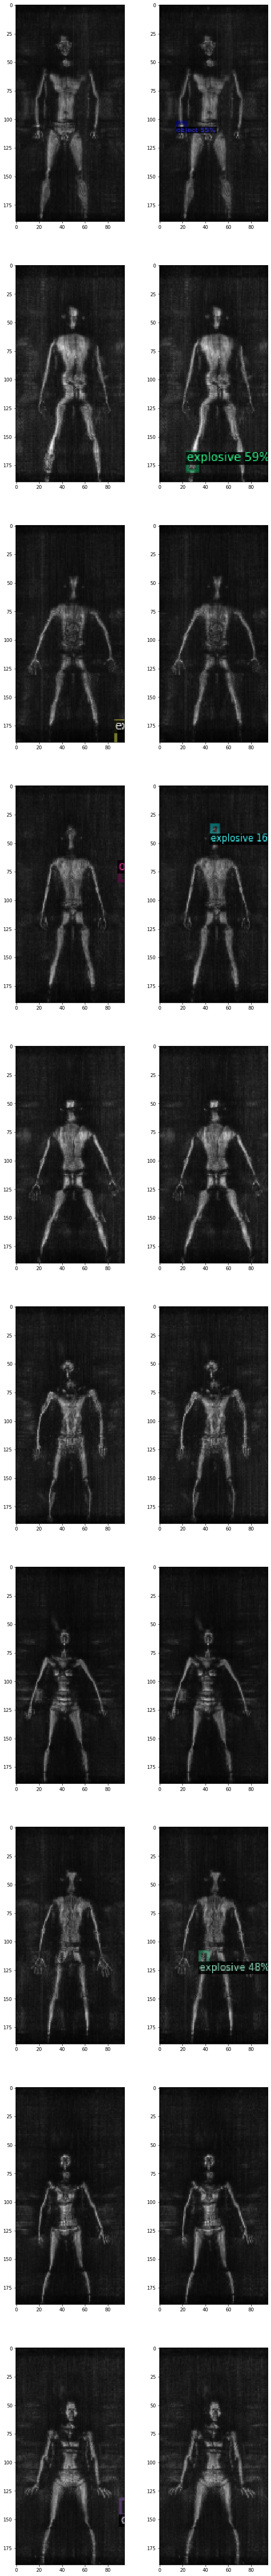

In [48]:
import cv2
i=1
plt.figure(figsize=(10,100))
for d in random.sample(dataset_dicts, 10):
    im = cv2.imread(d['file_name'])
    print(d['file_name'])
    outputs = predictor(im)
#     print(outputs)
    v = Visualizer(im[:,:,::-1],
                   metadata=object_metadata,
                   scale=0.5
    )
    vis = Visualizer(im[:,:,::-1],
                   metadata=object_metadata,
                   scale=0.5
    )
    v = v.draw_dataset_dict(d)
    vis = vis.draw_instance_predictions(outputs['instances'].to('cpu'))
    plt.subplot(10,2,i)
    plt.imshow(v.get_image()[:,:,::-1])
    plt.subplot(10,2,i+1)
    plt.imshow(vis.get_image()[:,:,::-1])
    i += 2

In [53]:
import os
from lxml import etree

anno_dir = '../sim_data_center/multi_class_detection/down/Annotations/'
xml_files=os.listdir(anno_dir)
for file in xml_files:
    # becasue I'm using Jupyterlab
    # which always creates the boring cache file/directory
    if not file[-3:] == 'xml':
        print('file'+' is not a xml')
        continue
    tree=etree.parse(os.path.join(anno_dir,file))
    root=tree.getroot()
    bboxes=[]
    for c in root.iter():
        if c.tag=='object':
            bboxes.append(c)
        elif c.tag=='width':
            width=int(c.text)
        elif c.tag=='height':
            height=int(c.text)
        elif c.tag=='depth':
            depth=int(c.text)
    if width != 190 or height != 380:
        print(file, end=',')
        print(f'(height,width,depth)=({height,width,depth})')
        continue
    for bbox in bboxes:
        box=[]
        for b in bbox.iter(): 
            if b.tag == 'xmin':
                xmin = int(b.text)
            elif b.tag == 'ymin':
                ymin = int(b.text)
            elif b.tag == 'xmax':
                xmax = int(b.text)
            elif b.tag == 'ymax':
                ymax = int(b.text)
        if xmin<0 or ymin<0 or xmax>189 or ymax>379:
            print(file, end=',')
            print(f'(height,width,depth)=({height,width,depth})',end=',')
            print(f'bbox = ({xmin,ymin,xmax,ymax})')

Train_12_05_005_268-1.xml,(height,width,depth)=((760, 380, 3))
Train_12_10_004_1541-1.xml,(height,width,depth)=((760, 380, 3))
Train_12_15_003_553-1.xml,(height,width,depth)=((760, 380, 3))
Train_12_21_004_957.xml,(height,width,depth)=((760, 380, 3))
Train_12_05_004_367-1.xml,(height,width,depth)=((760, 380, 3))
Train_12_06_003_676-1.xml,(height,width,depth)=((760, 380, 3))
Train_12_19_003_510-1.xml,(height,width,depth)=((760, 380, 3))
Train_12_06_005_978-1.xml,(height,width,depth)=((760, 380, 3))
Train_12_29_004_1546.xml,(height,width,depth)=((760, 380, 3))
Train_11_26_004_90.xml,(height,width,depth)=((760, 380, 3))
Train_12_27_005_1832-1.xml,(height,width,depth)=((760, 380, 3))
Train_11_27_005_960.xml,(height,width,depth)=((760, 380, 3))
Train_11_30_003_283-1.xml,(height,width,depth)=((760, 380, 3))
Train_12_13_004_1027.xml,(height,width,depth)=((760, 380, 3))
Train_12_05_004_662.xml,(height,width,depth)=((760, 380, 3))
Train_12_22_004_883.xml,(height,width,depth)=((760, 380, 3))
Tra

In [54]:
import cv2

In [62]:
img = cv2.imread('../sim_data_center/multi_class_detection/down/JPEGImages/033_AllLighters_20191018124011968_19002-1.jpg')

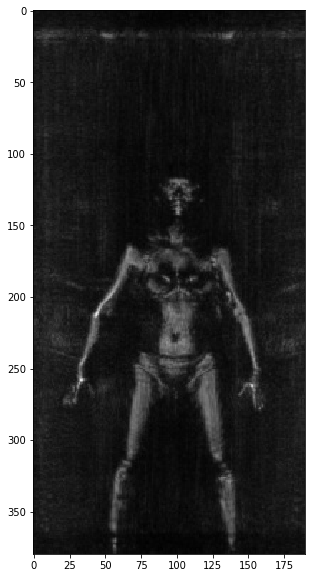

In [63]:
plt.figure(figsize=(10,10))
plt.imshow(img)